In [94]:
# Utility Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
from bayes_opt import BayesianOptimization

# CNN Libraries
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# XGBoost Library
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Library for Ignoring Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Defining the paths for the location where the images are stored
data_dir = 'Detect_solar_dust/'
clean_images_dir = data_dir + 'Clean'
dirty_images_dir = data_dir + 'Dusty'

In [5]:
# Defining universal variables to be used in coding cells below
random.seed(101)
SIZE = (224, 224)
BATCH_SIZE = 64
RANDOM_STATE = 101
GRAYSCALE = False
if GRAYSCALE == True:
    INPUT_SHAPE = SIZE + (1,)
else:
    INPUT_SHAPE = SIZE + (3,)

In [6]:
# Defining a function to load images
def load_images(directory, grayscale = GRAYSCALE, size = SIZE,
               use_augmented = True):
    
    destination_dir = directory + "_Discarded"
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
        
    images = []         # Creating a list to store the images in the form of array
    for filename in tqdm(os.listdir(directory)):
        if filename == "Augmented_images":
            continue
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
            height, width, _ = img.shape
            # move images with small dimenstions to the discarded folder
            if (height < 800 and width < 400 ) or (height < 400 and width < 800 ):
                shutil.move(os.path.join(directory, filename), os.path.join(destination_dir, filename))
                continue

            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, size)
            x = np.array(img)
            x = np.expand_dims(x, axis=0)
            images.append(x)
        except Exception as e:
            continue
    
    if use_augmented:
        directory = os.path.join(directory, "Augmented_images")
        for filename in tqdm(os.listdir(directory)):
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            try:
                height, width, _ = img.shape
                # move images with small dimenstions to the discarded folder
                if (height < 800 and width < 400 ) or (height < 400 and width < 800 ):
                    shutil.move(os.path.join(directory, filename), os.path.join(destination_dir, filename))
                    continue

                if grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, size)
                x = np.array(img)
                x = np.expand_dims(x, axis=0)
                images.append(x)
            except Exception as e:
                continue

    return images

In [40]:
# Defining a function to track the metrics such as accuracy and roc-auc scores
def metrics_tracker(y_test, y_predictions, cmap = "Blues"):

    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
    roc_auc = auc(fpr, tpr)
    print(f"AUC for our classifier is: {roc_auc}")
    if cmap == "Blues":
        axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    else:
        axes[0].plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_title("Receiver Operating Characteristics", fontsize = 10)
    axes[0].set_xlabel("False Positive Rate", fontsize = 10)
    axes[0].set_ylabel("True Positive Rate", fontsize = 10)
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].legend()
    axes[0].grid(True)

    sns.heatmap(confusion_matrix(y_predictions, y_test), annot = True,
               fmt = '.0f', ax = axes[1], cmap = cmap)
    axes[1].set_xlabel("Predicted Label", fontsize = 10)
    axes[1].set_ylabel("Actual Label", fontsize = 10)
    axes[1].set_title("Confusion Matrix", fontsize = 10)
    plt.tight_layout()
    plt.show()

    print("---------------------Classification Report---------------------")
    print(classification_report(y_predictions, y_test))

In [8]:
# Function used to convert probability outcomes to 0 or 1 respectively
def zero_one_classifier(predictions):
    y_predictions = []
    for prediction in predictions.reshape(1, -1)[0]:
        if prediction > 0.5:
            y_predictions.append(1)
        else:
            y_predictions.append(0)
    return y_predictions

In [9]:
# Loading the clean and dusty solar panel images from directories
# This can take about 2 minutes to run and load the images and convert them to array
clean_images_array = load_images(clean_images_dir, grayscale = GRAYSCALE)
dusty_images_array = load_images(dirty_images_dir, grayscale = GRAYSCALE)

100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [00:18<00:00, 26.20it/s]


In [10]:
# Making changes to shape of clean and dusty solar panel images based on
# whether we are using grayscale image or colored images

if not GRAYSCALE:
    clean_images_array = np.array(np.squeeze(clean_images_array))
    dusty_images_array = np.array(np.squeeze(dusty_images_array))
else:
    clean_images_array = np.array(clean_images_array)
    dusty_images_array = np.array(dusty_images_array)
    clean_images_array = clean_images_array.reshape(len(clean_images_array), 224, 224, 1)
    dusty_images_array = dusty_images_array.reshape(len(dusty_images_array), 224, 224, 1)

In [11]:
print("The total number of images of clean solar panels: {}".format(len(clean_images_array)))
print("The total number of images of dusty solar panels: {}".format(len(dusty_images_array)))
print('-----------------------------------------------------')
print("The shape of images of clean solar panels: {}".format(clean_images_array.shape))
print("The shape of images of dusty solar panels: {}".format(dusty_images_array.shape))

The total number of images of clean solar panels: 725
The total number of images of dusty solar panels: 492
-----------------------------------------------------
The shape of images of clean solar panels: (725, 224, 224, 3)
The shape of images of dusty solar panels: (492, 224, 224, 3)


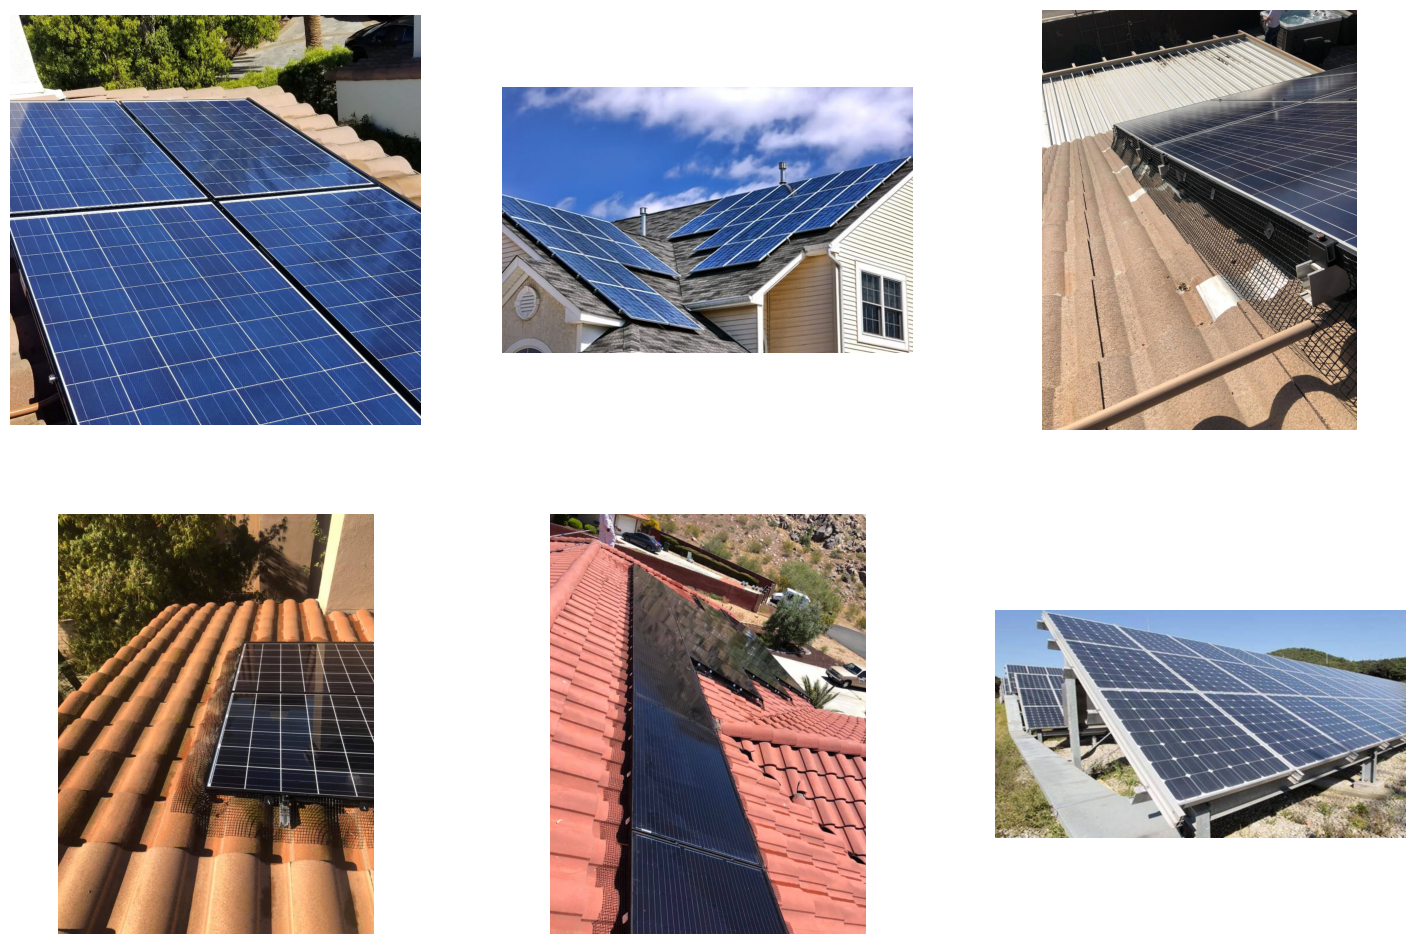

In [12]:
image_paths = os.listdir(clean_images_dir)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# randomly select 6 images to display as big images
big_image_paths = random.sample(image_paths, 6)

for i, image_path in enumerate(big_image_paths):
    image = os.path.join(clean_images_dir, image_path)
    img = cv2.imread(image, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()

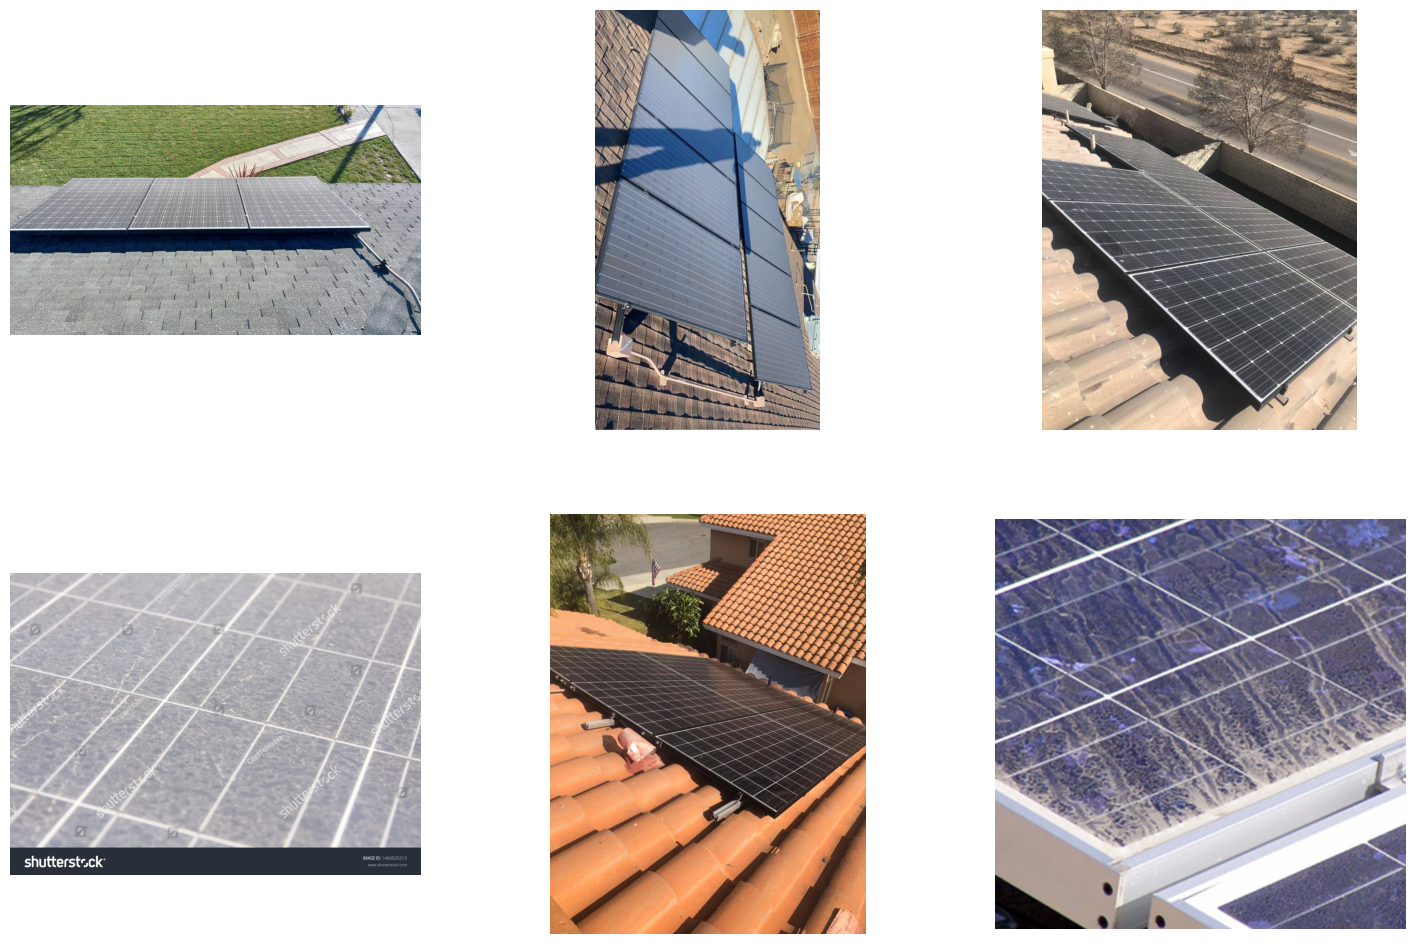

In [13]:
image_paths = os.listdir(dirty_images_dir)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# randomly select 6 images to display as big images
big_image_paths = random.sample(image_paths, 6)

for i, image_path in enumerate(big_image_paths):
    image = os.path.join(dirty_images_dir, image_path)
    img = cv2.imread(image, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()

In [14]:
dusty_labels = np.ones(len(dusty_images_array))
clean_labels = np.zeros(len(clean_images_array))

In [15]:
X = np.concatenate((clean_images_array, dusty_images_array))
y = np.concatenate((clean_labels, dusty_labels))

In [16]:
print("The shape of the input data: {}".format(X.shape))
print("The shape of the output data: {}".format(y.shape))

The shape of the input data: (1217, 224, 224, 3)
The shape of the output data: (1217,)


In [17]:
# Dividing the data into training, cross-validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                   random_state = RANDOM_STATE,
                                                   stratify = y, shuffle = True)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2,
                                                  random_state = RANDOM_STATE,
                                                  stratify = y_train, shuffle = True)

In [18]:
print("The shape of the input train data: {}".format(X_train.shape))
print("The shape of the input cross-validation data: {}".format(X_cv.shape))
print("The shape of the input test data: {}".format(X_test.shape))
print("----------------------------------------------------")
print("The shape of the output train data: {}".format(y_train.shape))
print("The shape of the output cross-validation data: {}".format(y_cv.shape))
print("The shape of the output test data: {}".format(y_test.shape))

The shape of the input train data: (778, 224, 224, 3)
The shape of the input cross-validation data: (195, 224, 224, 3)
The shape of the input test data: (244, 224, 224, 3)
----------------------------------------------------
The shape of the output train data: (778,)
The shape of the output cross-validation data: (195,)
The shape of the output test data: (244,)


In [19]:
# Performing normalization as part of feature engineering
X_train = X_train / 255
X_cv = X_cv / 255
X_test = X_test / 255

### CNN Feature Extractor

#### Defining CNN Feature Extractor

In [ ]:
# Defining CNN Feature Extractor
model = Sequential()
model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (2, 2), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(16, (2, 2), activation = 'relu'))
model.add(Flatten())
model.summary()
features_train = model.predict(X_train)
features_cv = model.predict(X_cv)
features_test = model.predict(X_test)

### Machine Learning Models

#### CNN Feature Extractor + Logistic Regression

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.7552924487123527


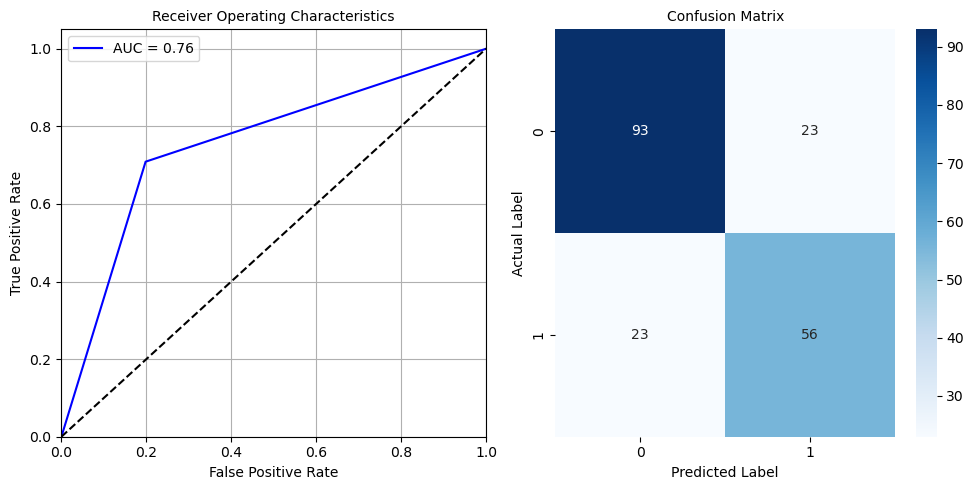

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       116
         1.0       0.71      0.71      0.71        79

    accuracy                           0.76       195
   macro avg       0.76      0.76      0.76       195
weighted avg       0.76      0.76      0.76       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.7108167770419425


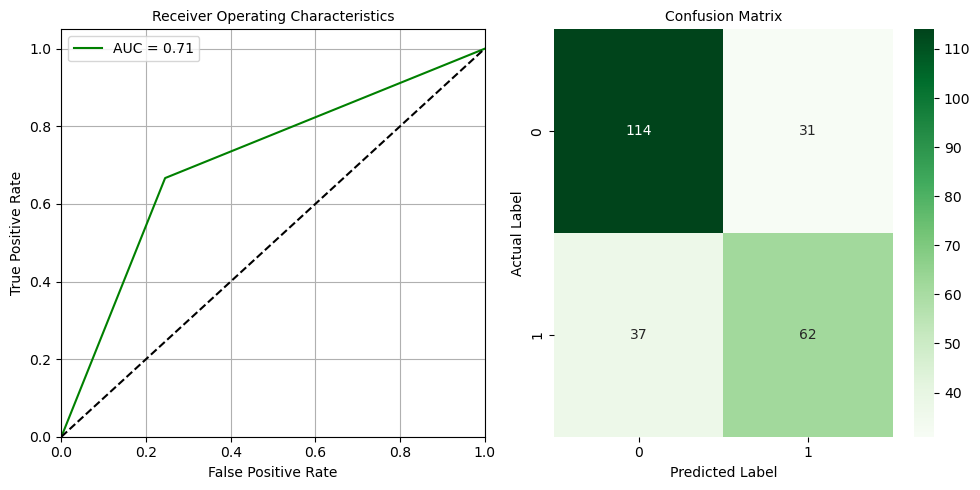

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       145
         1.0       0.67      0.63      0.65        99

    accuracy                           0.72       244
   macro avg       0.71      0.71      0.71       244
weighted avg       0.72      0.72      0.72       244



In [53]:
# Defining Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(features_train, y_train)
y_predictions_cv = lr_model.predict(features_cv)
y_predictions = lr_model.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")

#### 2.6.2 CNN Feature Extractor + Decision Tree Classifier

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.6052168170812238


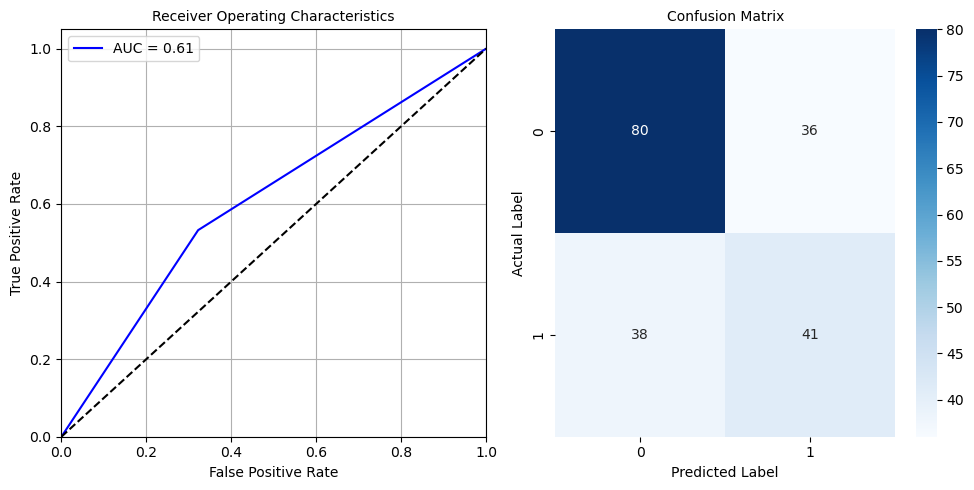

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68       116
         1.0       0.53      0.52      0.53        79

    accuracy                           0.62       195
   macro avg       0.61      0.60      0.60       195
weighted avg       0.62      0.62      0.62       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.6417145200984414


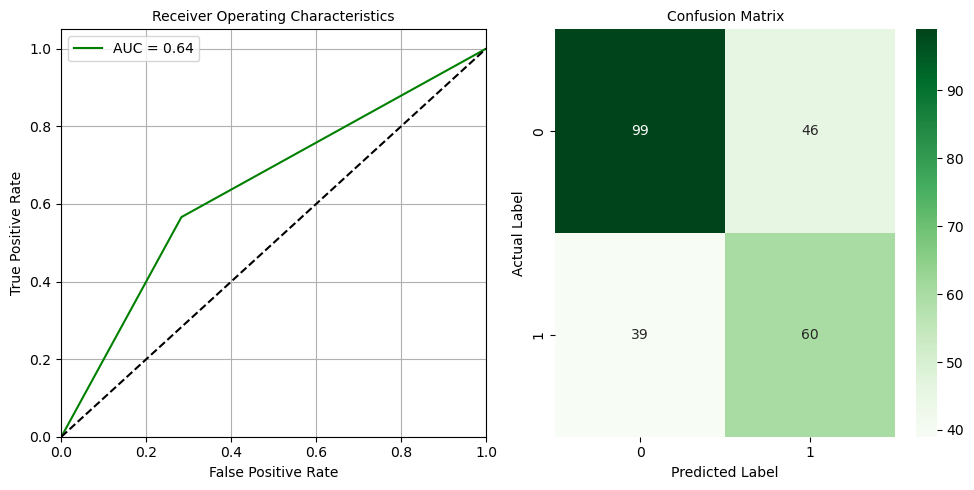

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70       145
         1.0       0.57      0.61      0.59        99

    accuracy                           0.65       244
   macro avg       0.64      0.64      0.64       244
weighted avg       0.66      0.65      0.65       244



In [54]:
# Defining Decision Tree Model
classifier = DecisionTreeClassifier(criterion = 'gini')
classifier.fit(features_train, y_train)
y_predictions_cv = classifier.predict(features_cv)
y_predictions = classifier.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")

#### 2.6.3 CNN Feature Extractor + Random Forest Classifier

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.7669578622816033


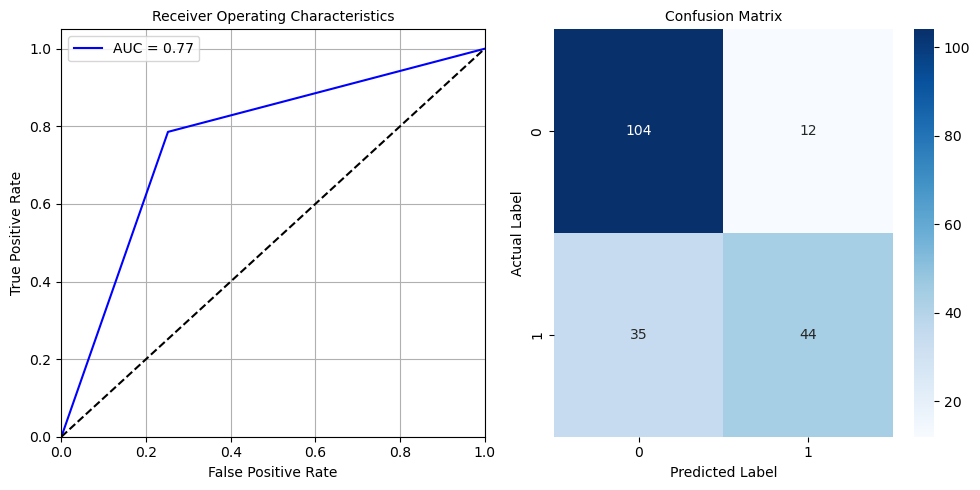

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82       116
         1.0       0.79      0.56      0.65        79

    accuracy                           0.76       195
   macro avg       0.77      0.73      0.73       195
weighted avg       0.76      0.76      0.75       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.7122153209109732


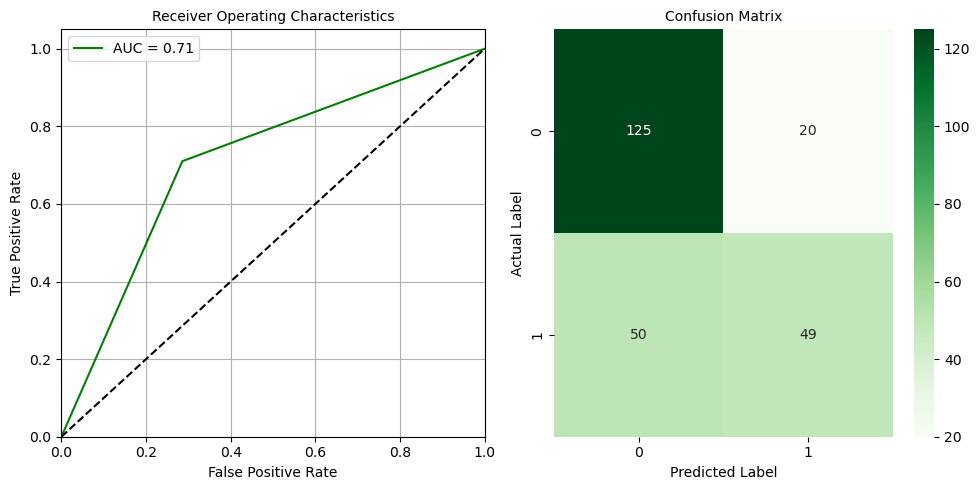

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78       145
         1.0       0.71      0.49      0.58        99

    accuracy                           0.71       244
   macro avg       0.71      0.68      0.68       244
weighted avg       0.71      0.71      0.70       244



In [55]:
# Defining Random Forest Model
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
classifier.fit(features_train, y_train)
y_predictions_cv = classifier.predict(features_cv)
y_predictions = classifier.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")

#### 2.6.4 CNN Feature Extractor + Support Vector Classifier 

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.7464878671775224


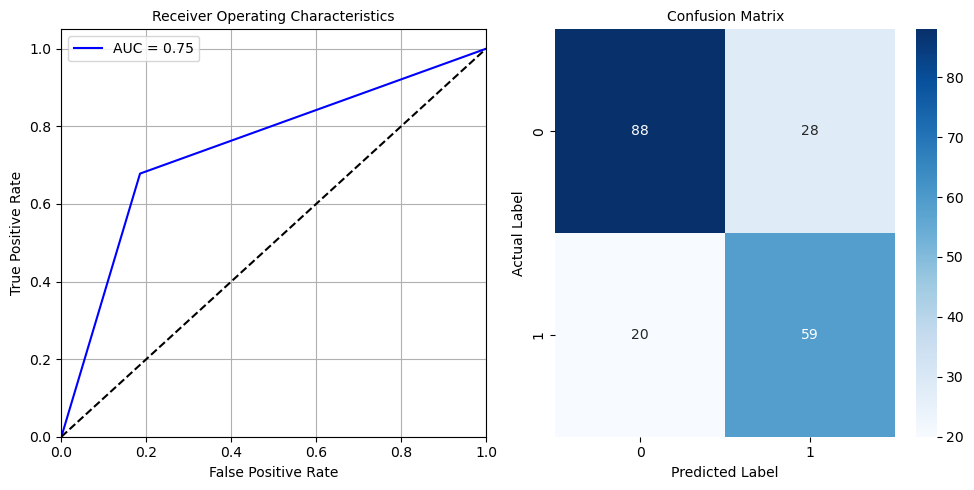

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.79       116
         1.0       0.68      0.75      0.71        79

    accuracy                           0.75       195
   macro avg       0.75      0.75      0.75       195
weighted avg       0.76      0.75      0.76       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.7322476935979871


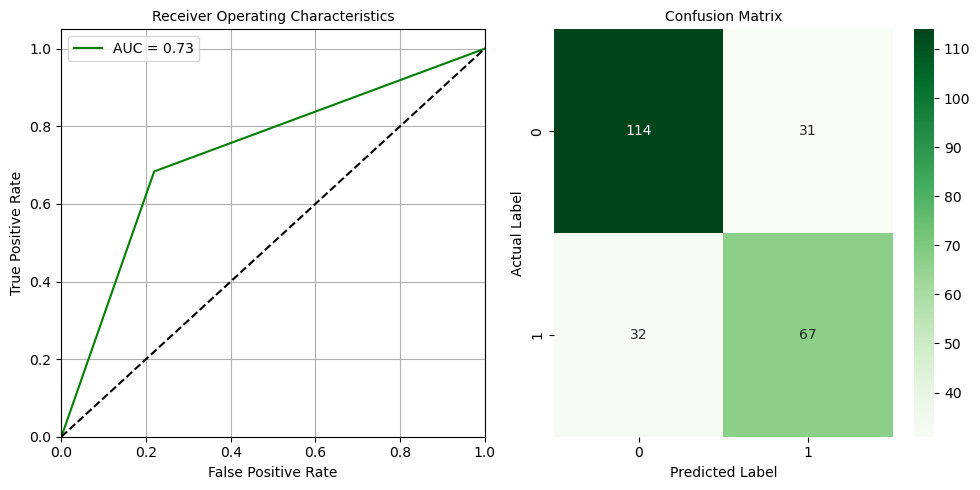

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78       145
         1.0       0.68      0.68      0.68        99

    accuracy                           0.74       244
   macro avg       0.73      0.73      0.73       244
weighted avg       0.74      0.74      0.74       244



In [56]:
# Defining Support Vector Classifier Model
classifier = SVC(kernel = 'linear')
classifier.fit(features_train, y_train)
y_predictions_cv = classifier.predict(features_cv)
y_predictions = classifier.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")

#### 2.6.5 CNN Feature Extractor + Naive Bayes Classifier

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.6391694725028058


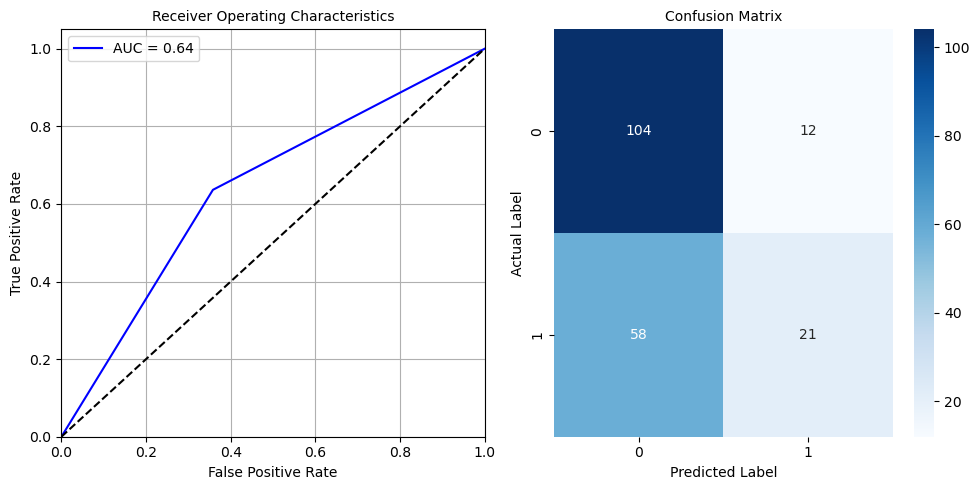

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.64      0.90      0.75       116
         1.0       0.64      0.27      0.38        79

    accuracy                           0.64       195
   macro avg       0.64      0.58      0.56       195
weighted avg       0.64      0.64      0.60       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.6747011755408475


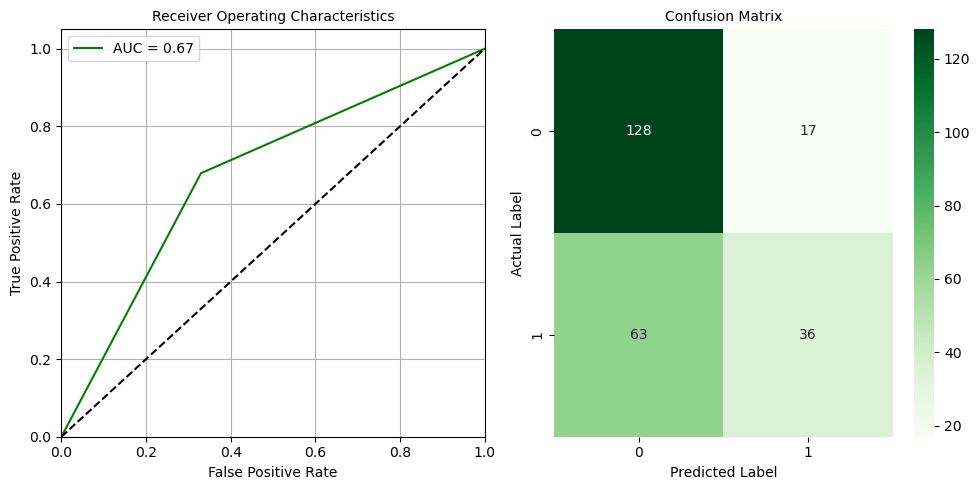

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76       145
         1.0       0.68      0.36      0.47        99

    accuracy                           0.67       244
   macro avg       0.67      0.62      0.62       244
weighted avg       0.67      0.67      0.64       244



In [57]:
# Defining Gaussian Naive Model
classifier = GaussianNB()
classifier.fit(features_train, y_train)
y_predictions_cv = classifier.predict(features_cv)
y_predictions = classifier.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")

#### 2.6.6 CNN Feature Extractor + K Nearest Neighbors Classifier

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.683967112024666


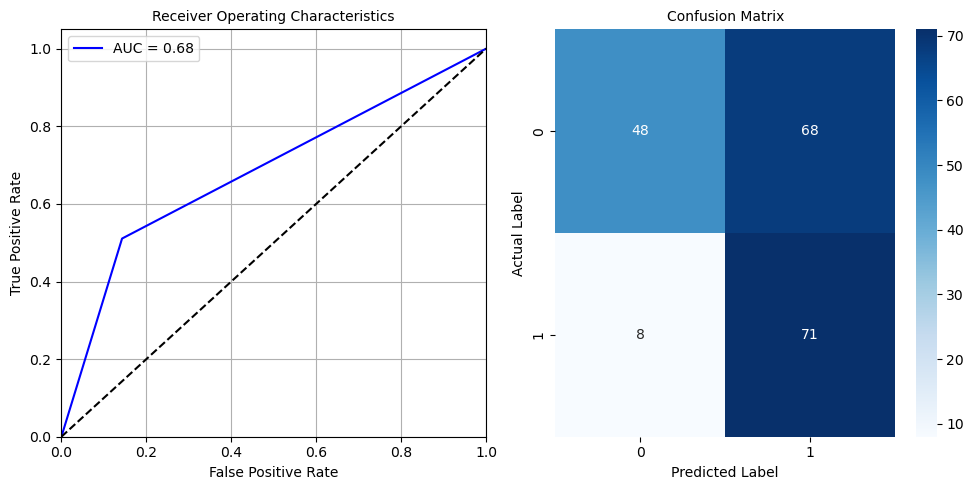

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.86      0.41      0.56       116
         1.0       0.51      0.90      0.65        79

    accuracy                           0.61       195
   macro avg       0.68      0.66      0.60       195
weighted avg       0.72      0.61      0.60       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.6771902131018154


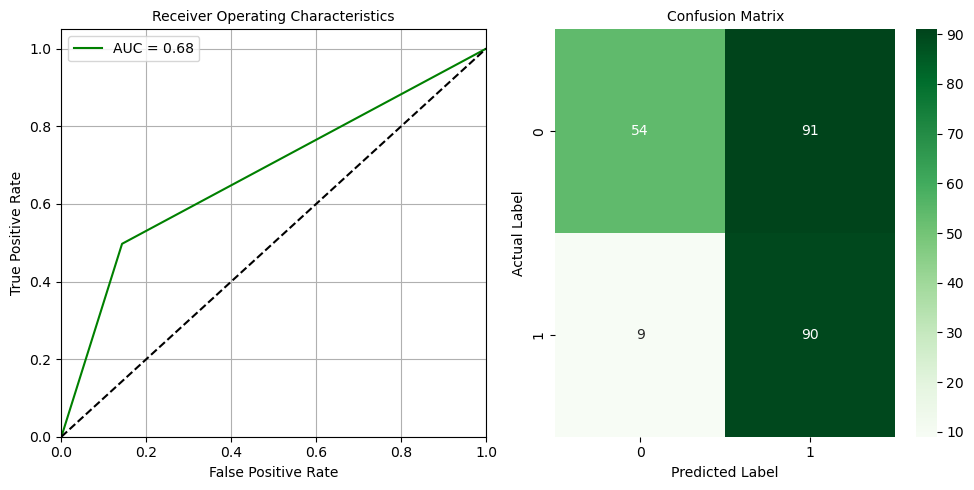

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.86      0.37      0.52       145
         1.0       0.50      0.91      0.64        99

    accuracy                           0.59       244
   macro avg       0.68      0.64      0.58       244
weighted avg       0.71      0.59      0.57       244



In [58]:
# Defining a K Neighbors Classifier Model 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(features_train, y_train)
y_predictions_cv = classifier.predict(features_cv)
y_predictions = classifier.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")

#### 2.6.7 CNN Feature Extractor + XGBoost Classifier

------------------------Cross-Validation Metrics------------------------
AUC for our classifier is: 0.7733739837398373


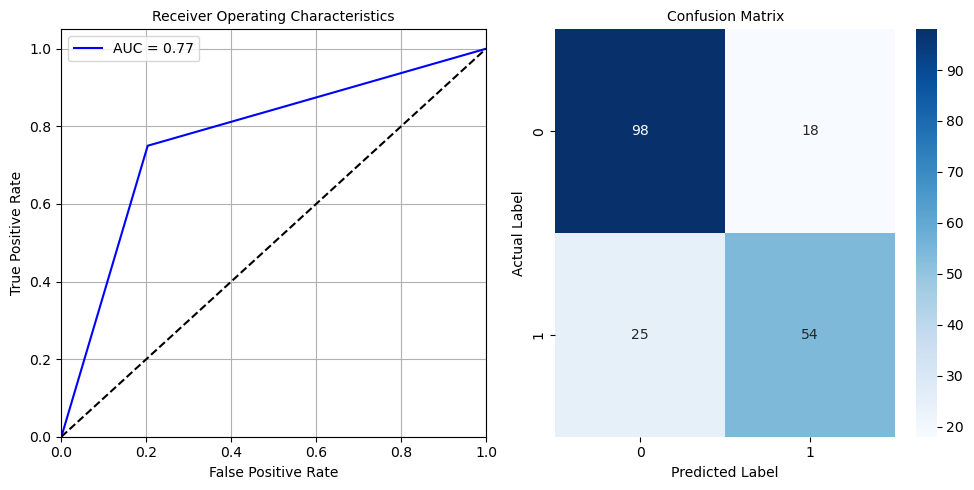

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       116
         1.0       0.75      0.68      0.72        79

    accuracy                           0.78       195
   macro avg       0.77      0.76      0.77       195
weighted avg       0.78      0.78      0.78       195

------------------------Test Metrics------------------------
AUC for our classifier is: 0.7129387113672079


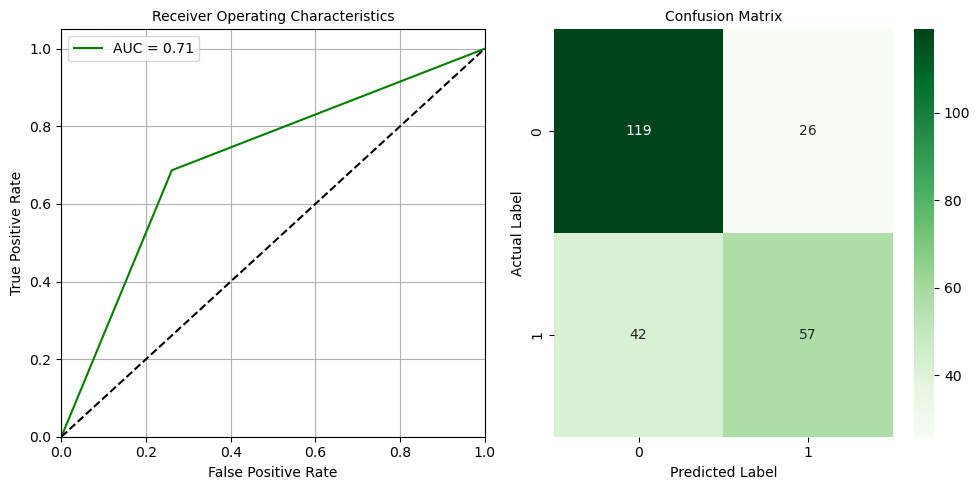

---------------------Classification Report---------------------
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       145
         1.0       0.69      0.58      0.63        99

    accuracy                           0.72       244
   macro avg       0.71      0.70      0.70       244
weighted avg       0.72      0.72      0.72       244



In [61]:
# Defining XGBoost Classification Model 
classifier = XGBClassifier(max_depth = 3, learning_rate = 0.1)
classifier.fit(features_train, y_train)
y_predictions_cv = classifier.predict(features_cv)
y_predictions = classifier.predict(features_test)

# Tracking Evaluation Metrics for Cross-Validation and Test Data
print(Fore.BLUE + "------------------------Cross-Validation Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions_cv, y_cv)
print(Fore.GREEN + "------------------------Test Metrics------------------------" + Style.RESET_ALL)
metrics_tracker(y_predictions, y_test, cmap = "Greens")